In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from google.cloud import bigquery



In [3]:
def plot_loss_accuracy(history, title=None):

    fig, ax = plt.subplots(1,2, figsize=(20,7))

    # --- LOSS ---

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- ACCURACY

    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

In [4]:
def plot_loss_accuracy_recall(history, title=None):

    fig, ax = plt.subplots(1,3, figsize=(20,7))

    # --- LOSS ---

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- ACCURACY

    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    # --- RECALL

    ax[2].plot(history.history['recall'])
    ax[2].plot(history.history['val_recall'])
    ax[2].set_title('Model Recall')
    ax[2].set_ylabel('Recall')
    ax[2].set_xlabel('Epoch')
    ax[2].legend(['Train', 'Test'], loc='best')
    ax[2].set_ylim((0,1))
    ax[2].grid(axis="x",linewidth=0.5)
    ax[2].grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

In [5]:
# df = pd.read_csv('../raw_data/archive/hmnist_28_28_RGB.csv')

In [6]:
def get_data_from_bq(
        gcp_project:str,
        query:str,
        data_has_header=True
    ) -> pd.DataFrame:
    """
    Retrieve `query` data from BigQuery
    """
    client = bigquery.Client(project=gcp_project)
    query_job = client.query(query)
    result = query_job.result()
    df = result.to_dataframe()
    df = df.astype("float64")
    return df

GCP_PROJECT = "skin-scan-461716"
BQ_DATASET = "skin_scan"

query = f"""
        SELECT *
        FROM `{GCP_PROJECT}`.{BQ_DATASET}.train_28x28
    """

df = get_data_from_bq(f"{GCP_PROJECT}", query)

In [7]:
df.columns

Index(['pixel0000', 'pixel0001', 'pixel0002', 'pixel0003', 'pixel0004',
       'pixel0005', 'pixel0006', 'pixel0007', 'pixel0008', 'pixel0009',
       ...
       'pixel2343', 'pixel2344', 'pixel2345', 'pixel2346', 'pixel2347',
       'pixel2348', 'pixel2349', 'pixel2350', 'pixel2351', 'label'],
      dtype='object', length=2353)

In [8]:
X = df.drop(columns=['label'])
y = df['label']

In [9]:
X_reshaped = X.values.reshape(-1, 28, 28, 3)

In [10]:
# Convert y to one-hot encoding
y_cat = to_categorical(y)
y_cat

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [11]:
X = X/255.0

In [12]:
X_train, X_test,y_train, y_test = train_test_split(X_reshaped, y_cat, test_size=0.3, random_state=42)

# Model Architecture

In [13]:
#Model Architecture ---

model = Sequential([
    Input(shape=(28, 28, 3)),  # or (28, 28, 3) for RGB
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.6),
    Dense(7, activation='softmax')
])

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,807 (221.90 KB)

 Trainable params: 56,807 (221.90 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy','recall']) # maybe recall

In [16]:
y_train.shape

(7010, 7)

In [17]:
es = EarlyStopping(patience=20, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32,verbose=2, validation_split=0.2, callbacks=[es])

Epoch 1/100
176/176 - 1s - 7ms/step - accuracy: 0.6435 - loss: 3.8387 - recall: 0.0214 - val_accuracy: 0.6705 - val_loss: 1.7813 - val_recall: 0.0000e+00
Epoch 2/100
176/176 - 1s - 4ms/step - accuracy: 0.6723 - loss: 1.7056 - recall: 0.0000e+00 - val_accuracy: 0.6712 - val_loss: 1.6362 - val_recall: 0.0000e+00
Epoch 3/100
176/176 - 1s - 4ms/step - accuracy: 0.6724 - loss: 1.5718 - recall: 0.0000e+00 - val_accuracy: 0.6712 - val_loss: 1.5160 - val_recall: 0.0000e+00
Epoch 4/100
176/176 - 1s - 4ms/step - accuracy: 0.6705 - loss: 1.4928 - recall: 0.0112 - val_accuracy: 0.6719 - val_loss: 1.4184 - val_recall: 0.0000e+00
Epoch 5/100
176/176 - 1s - 4ms/step - accuracy: 0.6724 - loss: 1.3781 - recall: 0.0000e+00 - val_accuracy: 0.6719 - val_loss: 1.3433 - val_recall: 0.0000e+00
Epoch 6/100
176/176 - 1s - 4ms/step - accuracy: 0.6724 - loss: 1.3122 - recall: 0.0000e+00 - val_accuracy: 0.6719 - val_loss: 1.2868 - val_recall: 0.0000e+00
Epoch 7/100
176/176 - 1s - 4ms/step - accuracy: 0.6724 - los

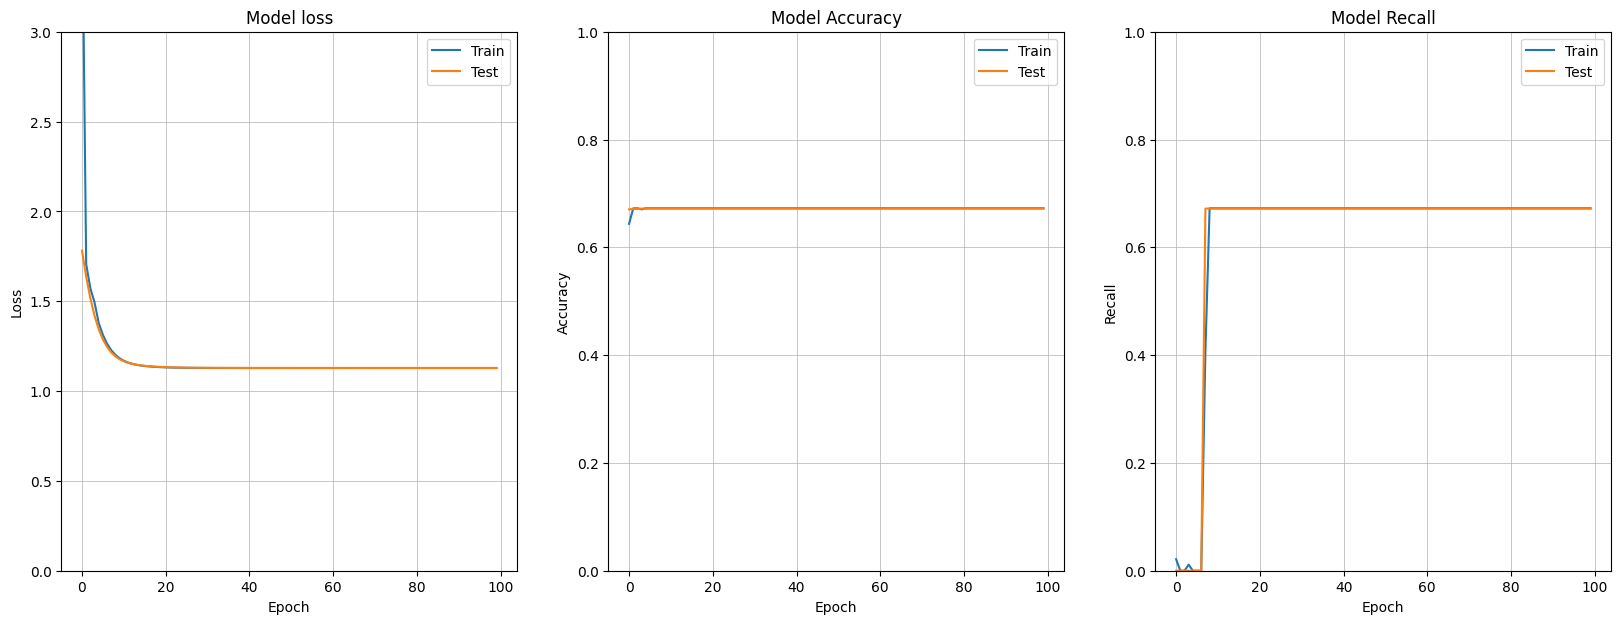

In [18]:
# plt.plot(history.history['accuracy'], label='train acc')
# plt.plot(history.history['val_accuracy'], label='val acc')
# plt.legend()
# plt.show()

plot_loss_accuracy_recall(history, title=None)

In [19]:
pd.DataFrame(history.history)

,accuracy,loss,recall,val_accuracy,val_loss,val_recall
0,0.643545,3.838733,0.021398,0.670471,1.781252,0.000000
1,0.672254,1.705583,0.000000,0.671184,1.636190,0.000000
2,0.672432,1.571801,0.000000,0.671184,1.515965,0.000000
3,0.670471,1.492761,0.011234,0.671897,1.418401,0.000000
4,0.672432,1.378098,0.000000,0.671897,1.343330,0.000000
...,...,...,...,...,...,...
95,0.672432,1.128283,0.672432,0.671897,1.128522,0.671897
96,0.672432,1.128273,0.672432,0.671897,1.128530,0.671897
97,0.672432,1.128239,0.672432,0.671897,1.128469,0.671897
98,0.672432,1.128271,0.672432,0.671897,1.128514,0.671897


In [20]:
np.max(history.history["val_accuracy"])

np.float64(0.671897292137146)

In [21]:
print("Loss,    Accuracy,   Recall")
model.evaluate(X_test, y_test)

Loss,    Accuracy,   Recall
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6696 - loss: 1.1189 - recall: 0.6696


[1.1385390758514404, 0.6628952026367188, 0.6628952026367188]